# EasyMarket

Third party libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from thefuzz import fuzz
from unidecode import unidecode


Container to hold abstractions

Ensure to create a config.ini file with the following contents:
```ini
[DEFAULT]
cloud_database_url = postgresql+psycopg2://<username>:<password>@<host>:<port>/<database>
local_database_url = sqlite+pysqlite:///<filepath>
```

In [2]:
from container import Container

container = Container()


In [3]:
purchases_repository = container.purchases_repository
purchases_df = purchases_repository.get_all()
purchases_df.head()


,description,unit
0,AMENDOIM CROCANTE PIMENTA VERM 90G DORI,PCE
1,SH+COND PANTENE HIDRO CAUTER,PCE
2,SAB REXONA ANTIBAC FRESH 84G C3,PCE
3,BISC NESFIT MIX DE GERGELIM 126G NESTLE,PCE
4,BARRA RITTER ZERO BRIGADEIRO C/3 75G,PCE


In [4]:
target = 'feijão'
target = unidecode(target.lower())
ratio_key = 'ratio'
personal_ratio_key = 'personal_ratio'


def personal_ratio(s1: str, s2: str) -> int:
    head = 0
    comparable = ''
    for c in s1:
        comparable += c
        ratio = fuzz.token_set_ratio(comparable, s2)
        if ratio > head:
            head = ratio
    return head


def apply_ratio(df: pd.DataFrame):
    df[ratio_key] = df.apply(lambda row: fuzz.token_set_ratio(row.description, target), axis=1)
    df.sort_values(by=ratio_key, ascending=False, inplace=True)
    return df


def apply_personal_ratio(df: pd.DataFrame):
    df[personal_ratio_key] = df.apply(
        lambda row: personal_ratio(row.description, target),
        axis=1
    )
    df.sort_values(by=personal_ratio_key, ascending=False, inplace=True)
    return df


def display_results(df: pd.DataFrame, key=ratio_key):
    plt.hist(df[ratio_key], bins=100)
    plt.show()

    return df.head()


Working on default data

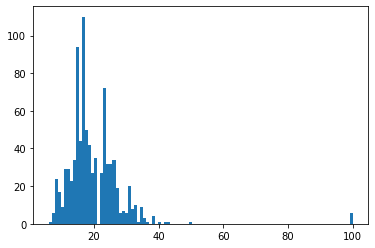

,description,unit,ratio
608,FEIJAO SUPANG 1KG,UN,100
353,FEIJAO VERMELHO PACHA 1kg,UN,100
352,FEIJAO PRETO KALDINHO 1kg T1,UN,100
165,FEIJAO VERMELHO PEREIRA 1kg T1,UN,100
213,FEIJAO PRETO CAMPO BOM 1kg T1,UN,100


In [5]:
purchases_df = purchases_repository.get_all()
purchases_df = apply_ratio(purchases_df)

display_results(purchases_df)


Working on lowercase data

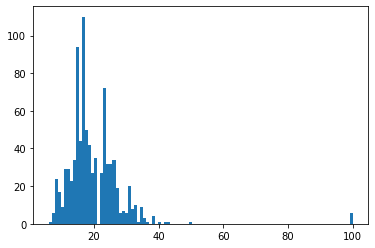

,description,unit,ratio
608,feijao supang 1kg,UN,100
353,feijao vermelho pacha 1kg,UN,100
352,feijao preto kaldinho 1kg t1,UN,100
165,feijao vermelho pereira 1kg t1,UN,100
213,feijao preto campo bom 1kg t1,UN,100


In [6]:
purchases_df = purchases_repository.get_all()
purchases_df.description = purchases_df.description.apply(
    lambda x: x.lower()
)
purchases_df = apply_ratio(purchases_df)

display_results(purchases_df)


Working only on ASCII characters

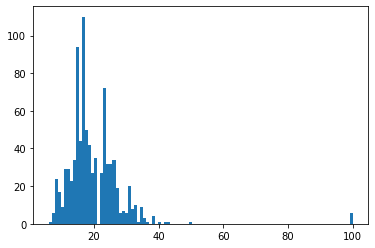

,description,unit,ratio
608,feijao supang 1kg,UN,100
353,feijao vermelho pacha 1kg,UN,100
352,feijao preto kaldinho 1kg t1,UN,100
165,feijao vermelho pereira 1kg t1,UN,100
213,feijao preto campo bom 1kg t1,UN,100


In [7]:
purchases_df = purchases_repository.get_all()
purchases_df.description = purchases_df.description.apply(
    lambda x: unidecode(x.lower())
)
purchases_df = apply_ratio(purchases_df)

display_results(purchases_df)


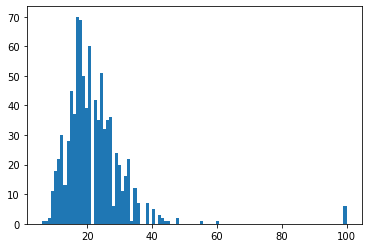

,description,unit,ratio
213,feijao preto campo bom t,UN,100
352,feijao preto kaldinho t,UN,100
460,feijao preto pacha t,UN,100
165,feijao vermelho pereira t,UN,100
608,feijao supang,UN,100


In [8]:
def prepare_df(df):
    # Remove non-ASCII characters
    df.description = df.description.apply(
        lambda x: unidecode(x.lower())
    )
    # Remove units (e.g. "kg")
    units = ['kg']
    for unit in units:
        df.description = df.description.apply(
            lambda x: x.replace(unit, '')
        )
    # Remove non-alphabetic characters (except for spaces)
    df.description = df.description.apply(
        lambda x: ''.join(c for c in x if c.isalpha() or c == ' ')
    )
    # Remove duplicate spaces
    df.description = df.description.apply(
        lambda x: ' '.join(x.split())
    )
    return df


purchases_df = purchases_repository.get_all()
purchases_df = prepare_df(purchases_df)
purchases_df = apply_ratio(purchases_df)

display_results(purchases_df)


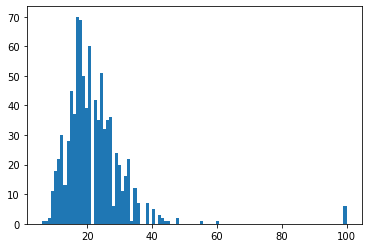

,description,unit,ratio,personal_ratio
213,feijao preto campo bom t,UN,100,100
460,feijao preto pacha t,UN,100,100
165,feijao vermelho pereira t,UN,100,100
608,feijao supang,UN,100,100
353,feijao vermelho pacha,UN,100,100


In [9]:
purchases_df = apply_personal_ratio(purchases_df)

display_results(purchases_df, personal_ratio_key)


In [10]:
google = container.google_service
q = target
hold = google.search(q)

print(f'Length: {len(hold)}')
hold


Length: 10


['Receita de feijão - TudoGostoso',
 'Feijão tradicional - Panelinha',
 'COMO FAZER FEIJÃO | Cozinha Básica - YouTube',
 'Receita de Feijão | CyberCook',
 'Como fazer feijão - Paladar - Estadão',
 'Como fazer feijão! - A Solução prática para o seu dia-a-dia!',
 'Como cozinhar feijão: o guia prático para iniciante | Consul',
 'Como cozinhar o feijão perfeito: dicas para deixá-lo delicioso',
 'Como Fazer Feijão | Receitas Nestlé',
 'Feijão Completo MAGGI | Receitas Nestlé']